In [211]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from comet_ml import Experiment
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt 

import seaborn as sns
import probscale
import matplotlib.ticker as mtick

from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

import shap

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel







In [31]:
COMET_API_KEY = os.environ.get("COMET_API_KEY")

In [35]:
experiment = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/0b36bd82643647aa8c12f8c72d1cfb64



### 5.1

In [11]:
train_data = pd.read_csv("train_2015_2018.csv", index_col=None)
test_data = pd.read_csv("test_2019.csv", index_col=None)

In [12]:
train_data.head()

,Unnamed: 0,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,...,number_friendly,number_opposing,power_play,distance,from_last_distance,angle,last_angle,time_from_last,change_angle,speed
0,0,7,00:51,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,6.0,...,5,5,0,34.5254,154.275727,0.1747,1.4248,51,0.0000,0.000000
1,1,9,01:05,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-79.0,0.0,...,5,5,0,10.0000,50.477718,0.0000,0.4939,65,0.0000,0.000000
2,2,10,01:06,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-75.0,-1.0,...,5,5,0,14.0357,4.123106,0.0713,0.0000,6,0.0713,0.687184
3,3,13,01:53,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,-36.0,...,5,5,0,49.5177,79.605276,0.8140,1.5137,53,0.0000,0.000000
4,4,21,02:37,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-61.0,-1.0,...,5,5,0,28.0179,22.472205,0.0357,0.8330,37,0.0000,0.000000


In [15]:
goal_data = train_data[['distance','angle','is_goal']]
goal_data

,distance,angle,is_goal
0,34.5254,0.1747,0
1,10.0000,0.0000,0
2,14.0357,0.0713,0
3,49.5177,0.8140,0
4,28.0179,0.0357,0
...,...,...,...
332737,13.8924,0.5281,1
332738,21.1896,0.3367,0
332739,24.3311,0.1651,0
332740,47.0956,0.0637,0


In [17]:
X = np.array(goal_data[['distance','angle']])
Y = np.array(goal_data[['is_goal']])

In [18]:
rng = np.random.RandomState(0)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=rng, shuffle=True)

In [39]:
model = XGBClassifier()
model.fit(X_train,y_train)

COMET WARNING: You must install graphviz to plot tree


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [40]:
pred = model.predict(X_test)

In [43]:
acc_ex1 = accuracy_score(y_test,pred)
experiment.log_metric("validation accuracy LR Shot's Distance for XGB", acc_ex1)
experiment.log_confusion_matrix(y_test,pred)
acc_ex1

0.9066852995537124

In [44]:
prob_predicted = model.predict_proba(X_test)


In [56]:
lr_probs = prob_predicted[:,1]
lr_auc = np.round((roc_auc_score(y_test, lr_probs)),4)
experiment.log_metric("AUC Score LR Shot's Distance for XGB ", lr_auc)


In [57]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
experiment.log_curve(f"roc-curve-class- Logistic Regression Distance for XGB",lr_fpr, lr_tpr)



{'web': 'https://www.comet.com/api/asset/download?assetId=f97f65643222483abbabd5388d4b9d83&experimentKey=0b36bd82643647aa8c12f8c72d1cfb64',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=f97f65643222483abbabd5388d4b9d83&experimentKey=0b36bd82643647aa8c12f8c72d1cfb64',
 'assetId': 'f97f65643222483abbabd5388d4b9d83'}

In [58]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift-6758-2/ift-6758/0b36bd82643647aa8c12f8c72d1cfb64
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     AUC Score LR Shot's Distance for XGB               : 0.7091
COMET INFO:     validation accuracy LR Shot's Distance for XGB [2] : (0.9066852995537124, 1.0)
COMET INFO:   Parameters:
COMET INFO:     begin_iteration : 0
COMET INFO:     end_iteration   : 99
COMET INFO:     objective       : binary:logistic
COMET INFO:     rank            : 0
COMET INFO:     world_size      : 1
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 2
COMET INFO:     curve                    : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-p

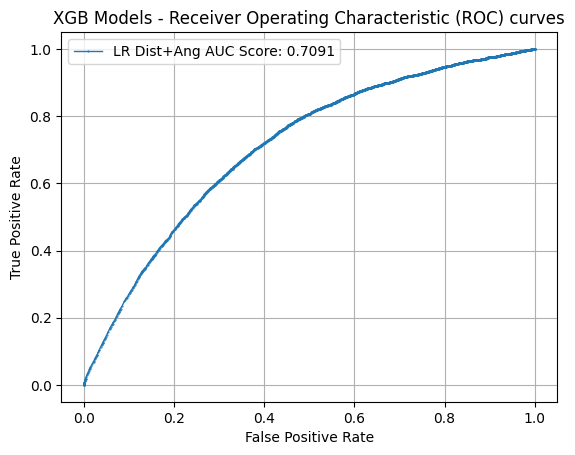

In [60]:
#ROC PLOT
plt.plot(lr_fpr, lr_tpr, marker='.', linewidth=1, markersize=1,label=f"LR Dist+Ang AUC Score: {lr_auc}")
plt.title('XGB Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [63]:
df_prob_goals = pd.DataFrame()
df_prob_goals['y_prob_lr'] = lr_probs
df_prob_goals['y_test'] = y_test
df_prob_goals.head()

,y_prob_lr,y_test
0,0.041576,0
1,0.107054,0
2,0.080906,0
3,0.143939,0
4,0.167333,0


In [67]:
d = np.sort(df_prob_goals['y_prob_lr'])

# Percentile values
p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])


perc = np.percentile(d, p)

In [68]:
def plot_gr_perc():

    x = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr'], bins=perc).reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    y = pd.cut(df_prob_goals['y_prob_lr'], bins=perc).reset_index()
    y =y.groupby('y_prob_lr', as_index=False).size()
    y.columns = ['y_prob_lr', 'count']

    sns.set_theme(style="white", palette=None)
    sns.lineplot(x=['10','20','30','40','50','60','70','80','90','100' ], y = 100*(x['count'] / y['count']), label = 'XGB- Dist + Ang')
    plt.title('Shot probabilty model percentile vs goal rate')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel("Goal rate")
    #ax.set_yscale('prob')
    fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    plt.gca().yaxis.set_major_formatter(yticks)
    plt.gca().invert_xaxis()
    plt.grid()

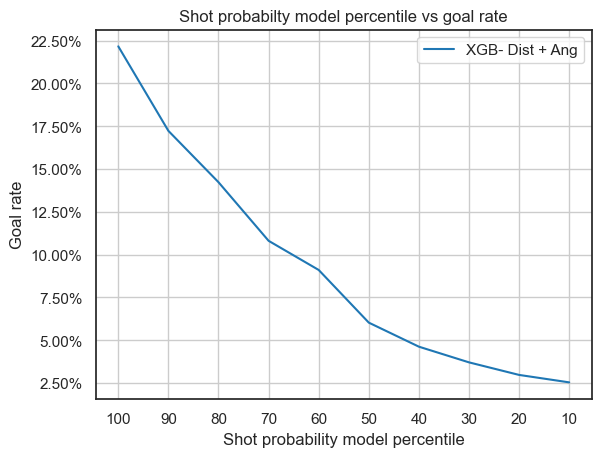

In [69]:
plot_gr_perc()

In [70]:
goals = df_prob_goals[df_prob_goals['y_test']==1]
goals

,y_prob_lr,y_test
5,0.083808,1
23,0.174695,1
35,0.261135,1
45,0.169257,1
61,0.173908,1
...,...,...
66486,0.065591,1
66488,0.165111,1
66523,0.127802,1
66527,0.124358,1


In [71]:
d = np.sort(goals['y_prob_lr'])

# Percentile values
p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])


perc = np.percentile(d, p)


In [72]:
def plot_partition_perc():

    x = pd.cut(goals['y_prob_lr'], bins=perc).reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    z = len(goals['y_test'])

    sns.set_theme(style="white", palette=None)
    sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x['count']/z))).cumsum(), label = 'XGB- Dist + Ang')
    
    plt.title('Shot probabilty model percentile vs goal rate')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel("Proportion")
    plt.yscale('prob')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    #fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
    #yticks = mtick.FormatStrFormatter(fmt)
    #plt.gca().yaxis.set_major_formatter(yticks)
    #xticks = mtick.FormatStrFormatter(fmt)
    #plt.gca().xaxis.set_major_formatter(xticks)
    #plt.gca().invert_xaxis()
    plt.grid()

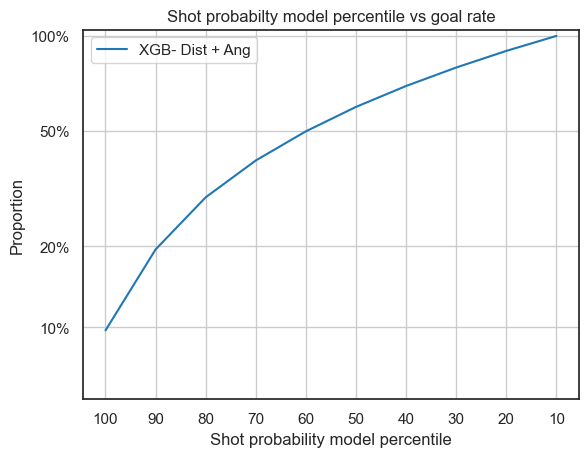

In [73]:
plot_partition_perc()

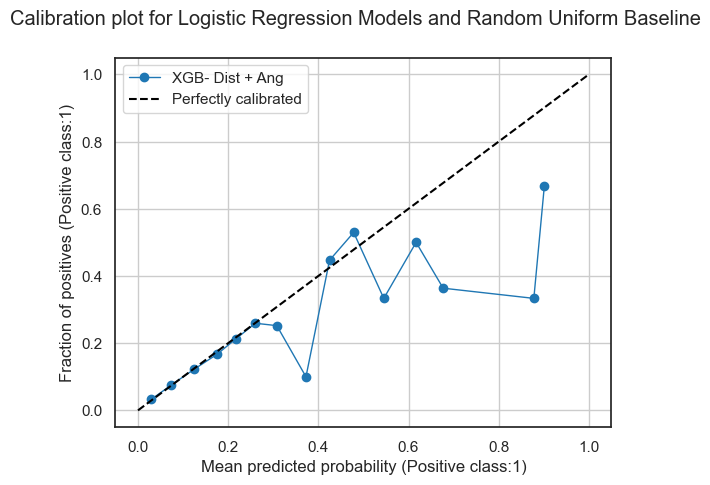

In [75]:
xgb_y, xgb_x = calibration_curve(y_test, lr_probs, n_bins=20)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgb_x,xgb_y, marker='o', linewidth=1, label='XGB- Dist + Ang')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#!!!!!!!!!! add figure to the comet!!!!!!!!

## 5.2

In [76]:
experiment_2 = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/83399a8bd8e147cbbe4da7fda652edc4



In [168]:
feature = ['period', 'coordinate_x', 'coordinate_y', 'shot_type', 'distance', 'angle', 'last_type', 'last_coord_x', 'last_coord_y', 'time_from_last', 'from_last_distance', 'rebound',
 'change_angle', 'speed','power_play', 'number_friendly', 'number_opposing']
 

In [169]:
goal_data_2 = train_data[feature]
goal_data_2

,period,coordinate_x,coordinate_y,shot_type,distance,angle,last_type,last_coord_x,last_coord_y,time_from_last,from_last_distance,rebound,change_angle,speed,power_play,number_friendly,number_opposing
0,1,-55.0,6.0,Wrist Shot,34.5254,0.1747,HIT,94.0,-34.0,51,154.275727,False,0.0000,0.000000,0,5,5
1,1,-79.0,0.0,Snap Shot,10.0000,0.0000,GIVEAWAY,-37.0,-28.0,65,50.477718,False,0.0000,0.000000,0,5,5
2,1,-75.0,-1.0,Snap Shot,14.0357,0.0713,SHOT,-79.0,0.0,6,4.123106,True,0.0713,0.687184,0,5,5
3,1,-55.0,-36.0,Wrist Shot,49.5177,0.8140,HIT,-91.0,35.0,53,79.605276,False,0.0000,0.000000,0,5,5
4,1,-61.0,-1.0,Tip-In,28.0179,0.0357,FACEOFF,-69.0,-22.0,37,22.472205,False,0.0000,0.000000,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332737,3,-77.0,7.0,Snap Shot,13.8924,0.5281,GIVEAWAY,-57.0,34.0,82,33.600595,False,0.0000,0.000000,0,5,5
332738,3,-69.0,7.0,Snap Shot,21.1896,0.3367,HIT,-68.0,-29.0,51,36.013886,False,0.0000,0.000000,0,5,5
332739,3,-65.0,-4.0,Snap Shot,24.3311,0.1651,SHOT,-69.0,7.0,55,11.704700,True,0.1716,0.212813,0,5,5
332740,3,42.0,3.0,Wrist Shot,47.0956,0.0637,STOP,NaN,NaN,50,NaN,False,0.0000,0.000000,0,5,5


In [170]:
goal_data_2.select_dtypes('object').columns

Index(['shot_type', 'last_type'], dtype='object')

In [171]:
le = LabelEncoder()
goal_data_2["shot_type"] = le.fit_transform(goal_data_2["shot_type"])
goal_data_2["last_type"] = le.fit_transform(goal_data_2["last_type"])

/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [172]:
X_2 = goal_data_2
Y_2 = np.array(train_data['is_goal'])

In [173]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.2, random_state=rng, shuffle=True)

In [174]:
X_train_2.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_2.fillna(0, inplace=True)

In [151]:
model_2 = XGBClassifier()
model_2.fit(X_train_2,y_train_2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [152]:
pred_2 = model_2.predict(X_test_2)

In [153]:
acc_ex2 = accuracy_score(y_test_2,pred_2)
experiment_2.log_metric("validation accuracy XGB", acc_ex2)
experiment_2.log_confusion_matrix(y_test_2,pred_2)
acc_ex2

COMET ERROR: Error creating confusion matrix: 0; ignoring


0.9063847691174923

In [154]:
prob_predicted_2 = model_2.predict_proba(X_test_2)

In [155]:
lr_probs_2 = prob_predicted_2[:,1]
lr_auc_2 = np.round((roc_auc_score(y_test_2, lr_probs_2)),4)
experiment.log_metric("AUC Score XGB", lr_auc_2)
lr_auc_2

0.7356

In [103]:
# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}



# skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 0)
# search_random = RandomizedSearchCV(model_2, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_2,y_train_2), verbose=3, random_state=0 )


# search_random.fit(X_train_2,y_train_2)

# hp_params = search_random.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=0.735 total time=  24.8s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=0.733 total time=  26.5s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=0.730 total time=  28.2s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100;, score=0.743 total time=  17.1s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100;, score=0.742 total time=  16.8s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100;, score=0.738 total time=  17.3s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=0.707 total time= 4.4min
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=0.704 total time= 4

In [156]:
hp_params

{'n_estimators': 100,
 'max_depth': 6,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7}

In [175]:
model_2_best = XGBClassifier(**hp_params)
model_2_best.fit(X_train_2, y_train_2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [176]:
pred_best = model_2_best.predict(X_test_2)
acc_ex2_best = accuracy_score(y_test_2,pred_best)
experiment_2.log_metric("validation accuracy XGB best", acc_ex2_best)
experiment_2.log_confusion_matrix(y_test_2,pred_best)
prob_predicted_2 = model.predict_proba(X_test_2)
lr2_probs_best = prob_predicted_2[:,1]
lr2_auc_best = np.round((roc_auc_score(y_test_2, lr2_probs_best)),4)
experiment_2.log_metric("AUC Score XGB best", lr2_auc_best)
print(acc_ex2_best, lr2_auc_best)
experiment_2.log_parameters(hp_params)
lr2_fpr_best, lr2_tpr_best, _ = roc_curve(y_test_2, lr2_probs_best)
experiment_2.log_curve(f"roc-curve-class- XGB best",lr2_fpr_best, lr2_tpr_best)



0.9059189469413514 0.7822


{'web': 'https://www.comet.com/api/asset/download?assetId=db4bfe799a3b4867be7ab1c13cbf5dd8&experimentKey=83399a8bd8e147cbbe4da7fda652edc4',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=db4bfe799a3b4867be7ab1c13cbf5dd8&experimentKey=83399a8bd8e147cbbe4da7fda652edc4',
 'assetId': 'db4bfe799a3b4867be7ab1c13cbf5dd8'}

In [140]:
hp_param = {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
hp_param_2 = {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.3}
hp_param_3 = {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
hp_param_4 = {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.3}


model1 = XGBClassifier(**hp_param)
model2 = XGBClassifier(**hp_param_2)
model3 = XGBClassifier(**hp_param_3)
model4 = XGBClassifier(**hp_param_4)
               
result1 = model1.fit(X_train_2, y_train_2)
result2 = model2.fit(X_train_2, y_train_2)
result3 = model3.fit(X_train_2, y_train_2)
result4 = model4.fit(X_train_2, y_train_2)

In [141]:
prob1_hp_predicted = model1.predict_proba(X_test_2)
lr1_hp_probs = prob1_hp_predicted[:, 1]
lr1_hp_auc = np.round((roc_auc_score(y_test_2, lr1_hp_probs)),4)
lr1_hp_fpr, lr1_hp_tpr, _ = roc_curve(y_test_2, lr1_hp_probs)

prob2_hp_predicted = model2.predict_proba(X_test_2)
lr2_hp_probs = prob2_hp_predicted[:, 1]
lr2_hp_auc = np.round((roc_auc_score(y_test_2, lr2_hp_probs)),4)
lr2_hp_fpr, lr2_hp_tpr, _ = roc_curve(y_test_2, lr2_hp_probs)

prob3_hp_predicted = model3.predict_proba(X_test_2)
lr3_hp_probs = prob3_hp_predicted[:, 1]
lr3_hp_auc = np.round((roc_auc_score(y_test_2, lr3_hp_probs)),4)
lr3_hp_fpr, lr3_hp_tpr, _ = roc_curve(y_test_2, lr3_hp_probs)

prob4_hp_predicted = model4.predict_proba(X_test_2)
lr4_hp_probs = prob4_hp_predicted[:, 1]
lr4_hp_auc = np.round((roc_auc_score(y_test_2, lr4_hp_probs)),4)
lr4_hp_fpr, lr4_hp_tpr, _ = roc_curve(y_test_2, lr4_hp_probs)


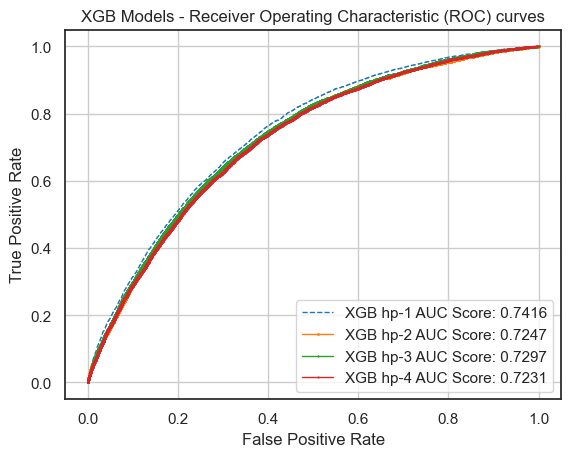

In [142]:
plt.plot(lr1_hp_fpr, lr1_hp_tpr, linestyle='--',linewidth=1, markersize=1, label=f"XGB hp-1 AUC Score: {lr1_hp_auc}")
plt.plot(lr2_hp_fpr, lr2_hp_tpr, marker='o', linewidth=1, markersize=1,label=f"XGB hp-2 AUC Score: {lr2_hp_auc}")
plt.plot(lr3_hp_fpr, lr3_hp_tpr, marker='*', linewidth=1, markersize=1,label=f"XGB hp-3 AUC Score: {lr3_hp_auc}")
plt.plot(lr4_hp_fpr, lr4_hp_tpr, marker='.', linewidth=1, markersize=1,label=f"XGB hp-4 AUC Score: {lr4_hp_auc}")
plt.title('XGB Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

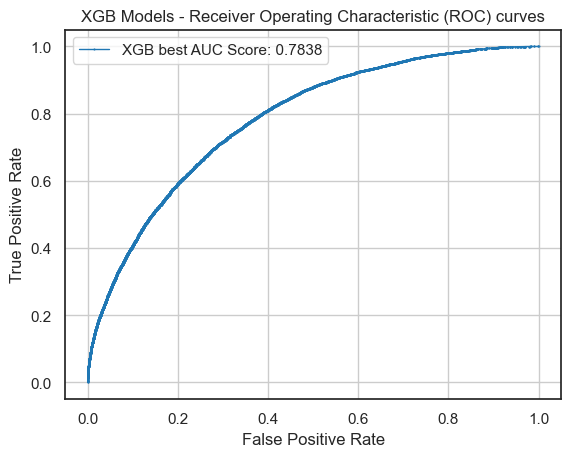

In [143]:
#ROC PLOT
plt.plot(lr2_fpr_best, lr2_tpr_best, marker='.', linewidth=1, markersize=1,label=f"XGB best AUC Score: {lr2_auc_best}")
plt.title('XGB Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [189]:
df2_prob_goals = pd.DataFrame()
df2_prob_goals['y_prob_lr'] = lr2_probs_best
df2_prob_goals['y_test'] = y_test_2
df2_prob_goals.head()

,y_prob_lr,y_test
0,0.024863,0
1,0.041794,0
2,0.134639,0
3,0.180084,0
4,0.205801,0


In [190]:
d_2 = np.sort(df2_prob_goals['y_prob_lr'])

# Percentile values
p_2 = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])


perc_2 = np.percentile(d_2, p_2)

In [193]:
def plot_gr_perc_2():

    x = pd.cut(df2_prob_goals[df2_prob_goals['y_test'] == 1]['y_prob_lr'], bins=perc_2).reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    y = pd.cut(df2_prob_goals['y_prob_lr'], bins=perc_2).reset_index()
    y =y.groupby('y_prob_lr', as_index=False).size()
    y.columns = ['y_prob_lr', 'count']

    sns.set_theme(style="white", palette=None)
    sns.lineplot(x=['10','20','30','40','50','60','70','80','90','100' ], y = 100*(x['count'] / y['count']), label = 'XGB best')
    plt.title('Shot probabilty model percentile vs goal rate')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel("Goal rate")
    #ax.set_yscale('prob')
    fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    plt.gca().yaxis.set_major_formatter(yticks)
    plt.gca().invert_xaxis()
    plt.grid()

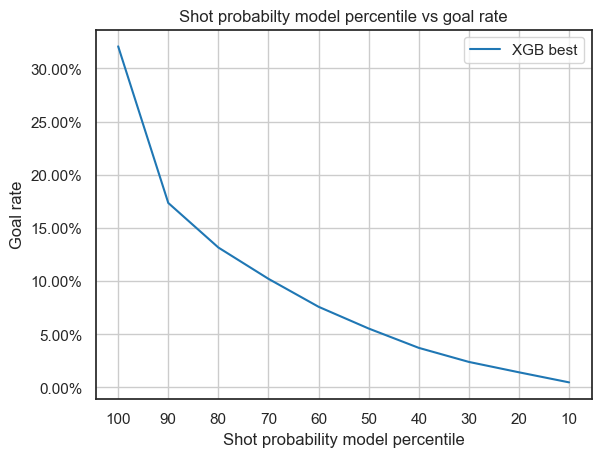

In [194]:
plot_gr_perc_2()

In [195]:
goals_2 = df2_prob_goals[df2_prob_goals['y_test']==1]
goals_2

,y_prob_lr,y_test
25,0.253874,1
28,0.114164,1
30,0.297236,1
53,0.074409,1
57,0.093426,1
...,...,...
66502,0.107748,1
66515,0.170182,1
66530,0.020505,1
66531,0.216290,1


In [196]:
d_2 = np.sort(goals_2['y_prob_lr'])

# Percentile values
p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])


perc_2 = np.percentile(d_2, p)


In [197]:
def plot_partition_perc_2():

    x = pd.cut(goals_2['y_prob_lr'], bins=perc_2).reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    z = len(goals_2['y_test'])

    sns.set_theme(style="white", palette=None)
    sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x['count']/z))).cumsum(), label = 'XGB best')
    
    plt.title('Shot probabilty model percentile vs goal rate')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel("Proportion")
    plt.yscale('prob')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    #fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
    #yticks = mtick.FormatStrFormatter(fmt)
    #plt.gca().yaxis.set_major_formatter(yticks)
    #xticks = mtick.FormatStrFormatter(fmt)
    #plt.gca().xaxis.set_major_formatter(xticks)
    #plt.gca().invert_xaxis()
    plt.grid()

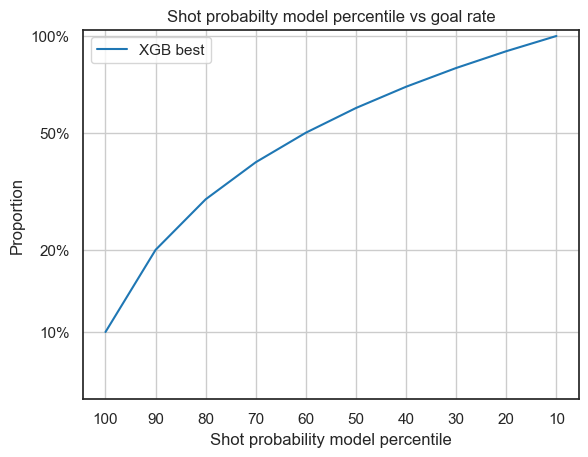

In [198]:
plot_partition_perc_2()

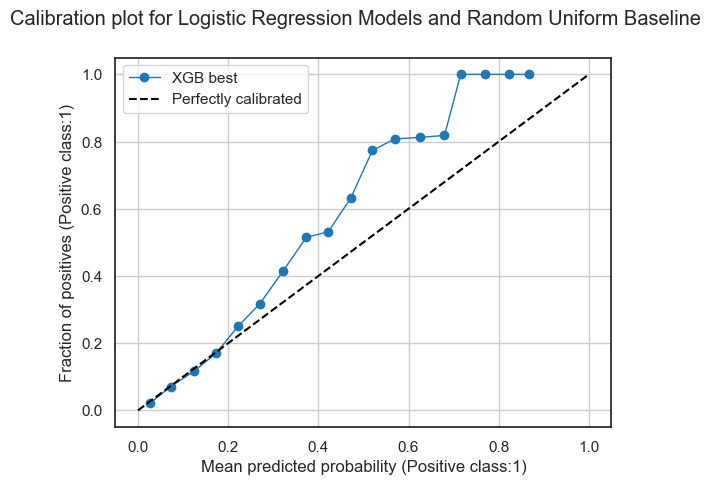

In [199]:
xgb_y, xgb_x = calibration_curve(y_test_2, lr2_probs_best, n_bins=20)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgb_x,xgb_y, marker='o', linewidth=1, label='XGB best')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#!!!!!!!!!! add figure to the comet!!!!!!!!

In [201]:
experiment_2.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift-6758-2/ift-6758/83399a8bd8e147cbbe4da7fda652edc4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     AUC Score XGB  [5]               : (0.7365, 0.7838)
COMET INFO:     AUC Score XGB best [2]           : (0.7822, 0.7839)
COMET INFO:     validation accuracy XGB [6]      : (0.9062946099866264, 0.9071811747734752)
COMET INFO:     validation accuracy XGB best [2] : (0.9059189469413514, 0.9066101669446573)
COMET INFO:   Parameters:
COMET INFO:     begin_iteration  : 0
COMET INFO:     colsample_bytree : 0.7
COMET INFO:     end_iteration    : 99
COMET INFO:     feature_names    : ['period', 'coordinate_x', 'coordinate_y', 'shot_type', 'distance', 'angle', 'last_type', 'last_coord_x', 'last_coord_y', 'time_from_last', 'from_last_distance', 'reb

## 5.3

In [202]:
experiment_3 = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/feb725fca6aa45d78a477fcf04a78bc2



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


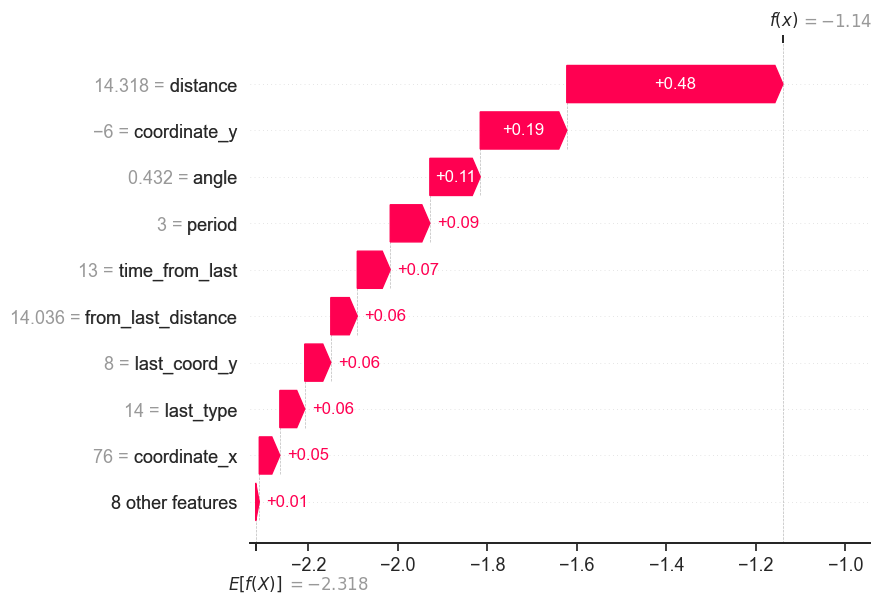

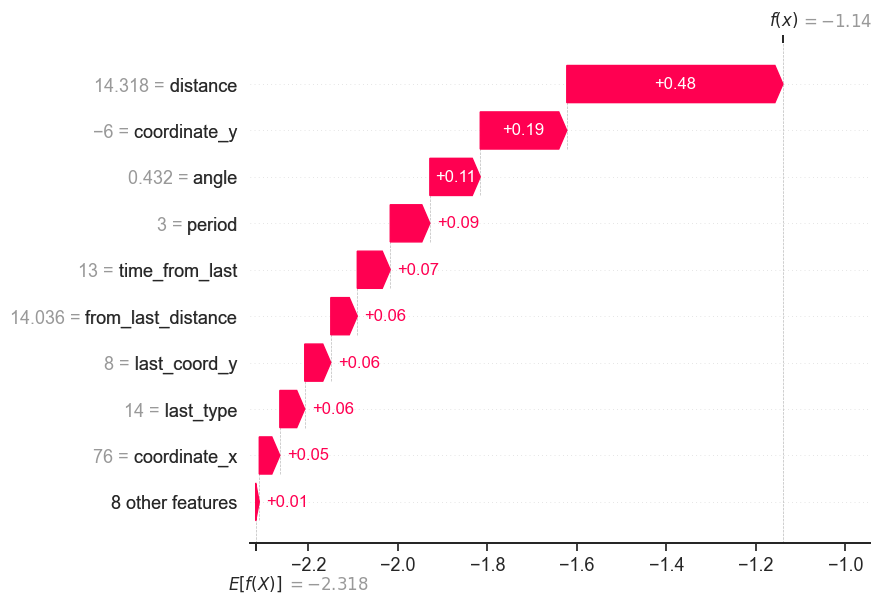

In [204]:
#use shap
explainer = shap.Explainer(model_2_best)
shap_values = explainer(X_train_2)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [231]:
#get the result with the best feature in SHAP
from matplotlib import pyplot
from pprint import pprint



X_train = X_train_2[['coordinate_y','time_from_last','angle','distance']]
X_test = X_test_2[['coordinate_y','time_from_last','angle','distance']]


model = XGBClassifier()
model.fit(X_train,y_train_2)
pred = model.predict(X_test)

acc_ex = accuracy_score(y_test_2,pred)
prob_predicted = model.predict_proba(X_test)
lr_probs = prob_predicted[:,1]
lr_auc_shap = np.round((roc_auc_score(y_test_2, lr_probs)),4)
print(acc_ex, lr_auc)
lr_fpr_shap, lr_tpr_shap, _ = roc_curve(y_test_2, lr_probs)

0.9060391591158394 0.7123


In [232]:
#LASSO
from sklearn import linear_model
from sklearn import feature_selection 

clf = linear_model.Lasso(alpha=0.1)
feature = feature_selection.SelectFromModel(estimator=clf,threshold="mean").fit(X_train_2,y_train_2)

feature_idx = feature.get_support()
feature_name = X_train_2.columns[feature_idx]

print(f'feature name is: {feature_name}')

X_train = X_train_2[feature_name]

#train with new feature

model = XGBClassifier()
model.fit(X_train,y_train_2)
pred = model.predict(X_test_2[feature_name])

acc_ex = accuracy_score(y_test_2,pred)
prob_predicted = model.predict_proba(X_test_2[feature_name])
lr_probs = prob_predicted[:,1]
lr_auc_lasso = np.round((roc_auc_score(y_test_2, lr_probs)),4)
print(acc_ex, lr_auc)
lr_fpr_lasso, lr_tpr_lasso, _ = roc_curve(y_test_2, lr_probs)


feature name is: Index(['distance', 'time_from_last', 'power_play'], dtype='object')
0.9060992652030835 0.7123


In [233]:
#Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train_2, y_train_2)
feature = feature_selection.SelectFromModel(estimator=clf,threshold="mean").fit(X_train_2,y_train_2)

feature_idx = feature.get_support()
feature_name = X_train_2.columns[feature_idx]

print(f'feature name is: {feature_name}')

X_train = X_train_2[feature_name]

#train with new feature

model = XGBClassifier()
model.fit(X_train,y_train_2)
pred = model.predict(X_test_2[feature_name])

acc_ex = accuracy_score(y_test_2,pred)
prob_predicted = model.predict_proba(X_test_2[feature_name])
lr_probs = prob_predicted[:,1]
lr_auc_tree = np.round((roc_auc_score(y_test_2, lr_probs)),4)
print(acc_ex, lr_auc)
lr_fpr_tree, lr_tpr_tree, _ = roc_curve(y_test_2, lr_probs)



feature name is: Index(['coordinate_x', 'coordinate_y', 'distance', 'angle', 'last_coord_x',
       'last_coord_y', 'time_from_last', 'from_last_distance'],
      dtype='object')
0.9057536552014305 0.7123


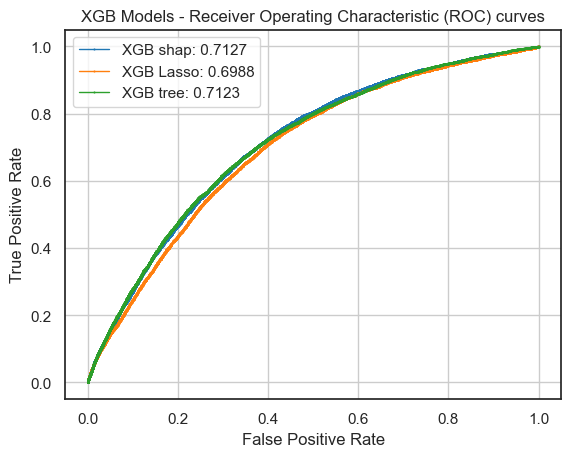

In [234]:
plt.plot(lr_fpr_shap, lr_tpr_shap, marker='.', linewidth=1, markersize=1,label=f"XGB shap: {lr_auc_shap}")
plt.plot(lr_fpr_lasso, lr_tpr_lasso, marker='.', linewidth=1, markersize=1,label=f"XGB Lasso: {lr_auc_lasso}")
plt.plot(lr_fpr_tree, lr_tpr_tree, marker='.', linewidth=1, markersize=1,label=f"XGB tree: {lr_auc_tree}")
plt.title('XGB Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
          